In [4]:
!pip install -q kaggle

In [7]:
! mkdir ~/.kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle competitions download -c dogs-vs-cats

 99% 800M/812M [00:08<00:00, 138MB/s]
100% 812M/812M [00:08<00:00, 99.9MB/s]


In [14]:
! unzip "dogs-vs-cats" -d .

Archive:  dogs-vs-cats.zip
  inflating: ./sampleSubmission.csv  
  inflating: ./test1.zip             
  inflating: ./train.zip             


In [15]:
!mkdir train
!mkdir train/content
!mkdir train/content/cat
!mkdir train/content/dog

! unzip "train.zip" -d ./traindata
! unzip "test1.zip" -d ./testdata

Streaming output truncated to the last 5000 lines.
  inflating: ./testdata/test1/5499.jpg  
  inflating: ./testdata/test1/55.jpg  
  inflating: ./testdata/test1/550.jpg  
  inflating: ./testdata/test1/5500.jpg  
  inflating: ./testdata/test1/5501.jpg  
  inflating: ./testdata/test1/5502.jpg  
  inflating: ./testdata/test1/5503.jpg  
  inflating: ./testdata/test1/5504.jpg  
  inflating: ./testdata/test1/5505.jpg  
  inflating: ./testdata/test1/5506.jpg  
  inflating: ./testdata/test1/5507.jpg  
  inflating: ./testdata/test1/5508.jpg  
  inflating: ./testdata/test1/5509.jpg  
  inflating: ./testdata/test1/551.jpg  
  inflating: ./testdata/test1/5510.jpg  
  inflating: ./testdata/test1/5511.jpg  
  inflating: ./testdata/test1/5512.jpg  
  inflating: ./testdata/test1/5513.jpg  
  inflating: ./testdata/test1/5514.jpg  
  inflating: ./testdata/test1/5515.jpg  
  inflating: ./testdata/test1/5516.jpg  
  inflating: ./testdata/test1/5517.jpg  
  inflating: ./testdata/test1/5518.jpg  
  inflatin

In [23]:
!ls test/cat/

ls: cannot access 'test/cat/': No such file or directory


In [25]:
!bash -c 'mv traindata/train/cat.{0..4000}.jpg train/content/cat'
!bash -c 'mv traindata/train/dog.{0..4000}.jpg train/content/dog'

In [26]:
!mkdir ./test
!mkdir ./test/dog
!mkdir ./test/cat

In [27]:
!bash -c 'mv traindata/train/cat.{5000..6000}.jpg test/cat'
!bash -c 'mv traindata/train/dog.{5000..6000}.jpg test/dog'

In [28]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)


training_set = train_datagen.flow_from_directory('train/content/', target_size = (64, 64), batch_size = 32, class_mode = 'binary')

# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('test/', target_size = (64, 64), batch_size = 32, class_mode = 'binary')

Found 8002 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


In [33]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [34]:
# Part 2 - Building the CNN
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
#cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
## For Binary Classification
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))


cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [35]:
# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
251/251 [==============================] - 44s 159ms/step - loss: 0.9340 - accuracy: 0.5626 - val_loss: 0.7697 - val_accuracy: 0.6379
Epoch 2/15
251/251 [==============================] - 40s 159ms/step - loss: 0.7521 - accuracy: 0.6461 - val_loss: 0.6773 - val_accuracy: 0.6988
Epoch 3/15
251/251 [==============================] - 38s 151ms/step - loss: 0.6855 - accuracy: 0.6747 - val_loss: 0.6917 - val_accuracy: 0.7113
Epoch 4/15
251/251 [==============================] - 46s 182ms/step - loss: 0.6634 - accuracy: 0.6888 - val_loss: 0.5950 - val_accuracy: 0.7168
Epoch 5/15
251/251 [==============================] - 38s 151ms/step - loss: 0.6307 - accuracy: 0.7008 - val_loss: 0.6392 - val_accuracy: 0.7493
Epoch 6/15
251/251 [==============================] - 41s 163ms/step - loss: 0.5947 - accuracy: 0.7222 - val_loss: 0.5776 - val_accuracy: 0.7438
Epoch 7/15
251/251 [==============================] - 36s 143ms/step - loss: 0.5828 - accuracy: 0.7254 - val_loss: 0.5900 - val_ac

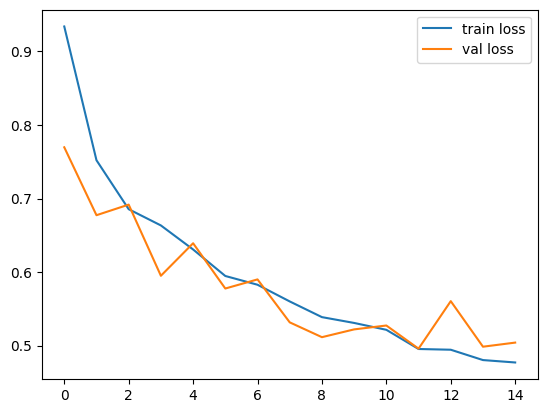

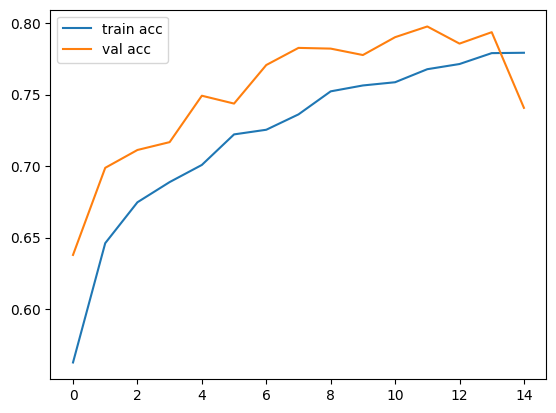

<Figure size 640x480 with 0 Axes>

In [36]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [37]:
from tensorflow.keras.models import load_model

cnn.save('model_rcat_dog.h5')


from tensorflow.keras.models import load_model

# load model
model = load_model('model_rcat_dog.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [40]:
!ls test/dog/dog.5015.jpg

test/dog/dog.5015.jpg


In [41]:
#  Part 4 - Making a single prediction

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('test/dog/dog.5015.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
result

1/1 [==============================] - 0s 167ms/step


array([[0.12769172]], dtype=float32)

In [42]:
!ls test/cat/cat.5017.jpg

test/cat/cat.5017.jpg


In [43]:
# Part 4 - Making a single prediction

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('test/cat/cat.5017.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
result

1/1 [==============================] - 0s 22ms/step


array([[-3.0696814]], dtype=float32)

In [44]:
if result[0]<0:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is cat
